#Section 1: Setup

## 1.1 Install required packages

In [1]:
# Install the required packages
!pip install torch torchvision pytorch-lightning einops torchinfo wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 46.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux

## 1.2 Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.3 Change to project directory

In [3]:
# Change to project directory
import os
project_path = '/content/drive/MyDrive/ViT-implementation'  # Update with your project path
os.chdir(project_path)

# Section 2: Data Loading and Preprocessing

# 2.1 Test DataLoader

In [4]:
# Import DataLoader
from utils.data import get_dataloaders

# Load DataLoader for a specific configuration
data_params = {
    "image_size": 32,
    "batch_size": 16,
    "num_images_per_class": 100,
    "train_ratio": 0.8
}
train_dataloader, test_dataloader = get_dataloaders(
    image_size=data_params["image_size"],
    batch_size=data_params["batch_size"],
    num_images_per_class=data_params["num_images_per_class"],
    train_ratio=data_params["train_ratio"]
)

# Check DataLoader
images, labels = next(iter(train_dataloader))
print(f"Loaded {len(images)} images with labels: {labels}")

Files already downloaded and verified
Loaded 16 images with labels: tensor([5, 5, 7, 0, 5, 1, 5, 2, 3, 6, 6, 8, 4, 1, 3, 4])


## Section 2.2: Visualize a Batch of Images

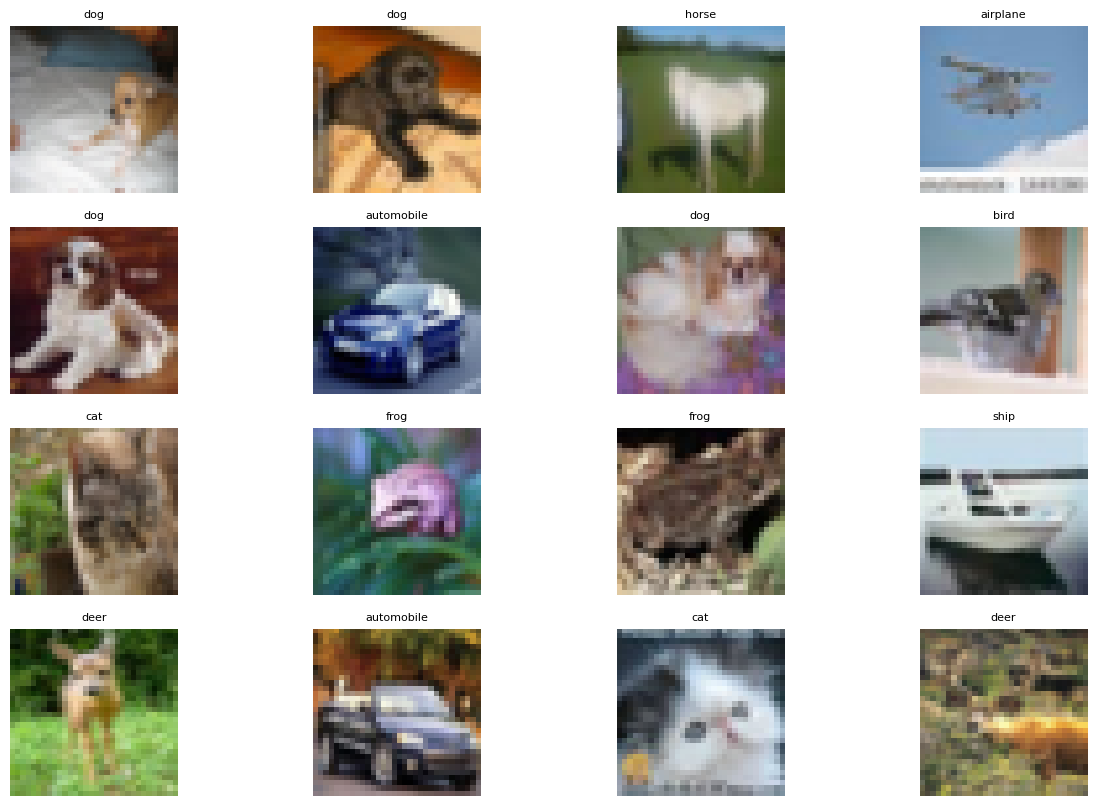

In [5]:
# Import visualization function
from utils.visualization import visualize_batch

# Setting manual seed
import torch
torch.manual_seed(42)

# Visualize a batch of images
idx_to_label = {
    0 : 'airplane',
    1 : 'automobile',
    2 : 'bird',
    3 : 'cat',
    4 : 'deer',
    5 : 'dog',
    6 : 'frog',
    7 : 'horse',
    8 : 'ship',
    9 : 'truck'
}

visualize_batch(images, labels, idx_to_label)

# Section 3: Model Testing

## 3.1 Test ViT Model

In [6]:
# Import ViTOptimized
from models.vit_optimized import ViTOptimized

# Initialize ViT Model
model_args = {
    "num_classes": 10,
    "embed_dim": 768,
    "depth": 12,
    "num_heads": 12,
    "mlp_dim": 3072,
    "dropout": 0.1
}
vit_model = ViTOptimized(**model_args)

# Generate dummy images for testing
images = torch.randn(16, 3, 32, 32)  # Batch size 16, 3 channels, 32x32 images

# Forward pass
output = vit_model(images)
print(f"ViT Model output shape: {output.shape}")

ViTOptimized input shape: torch.Size([16, 3, 32, 32])
After patch projection shape: torch.Size([16, 768, 8, 8])
After flatten and transpose shape: torch.Size([16, 64, 768])
ViT Model output shape: torch.Size([16, 10])


## 3.2 Test Hybrid Model

In [7]:
# Import HybridModel and ExtendedResNet
from models.hybrid import HybridModel, ExtendedResNet
from models.vit_optimized import ViTOptimized

# Initialize ResNet
resnet_args = {
    "block_units": [3, 4, 6, 3],
    "width_factor": 1,
    "out_channels": 768
}
resnet_model = ExtendedResNet(**resnet_args)

# Initialize ViT
vit_args = {
    "embed_dim": 768,
    "num_classes": 10,
    "num_heads": 12,
    "depth": 12,
    "mlp_dim": 3072,
    "dropout": 0.1
}
vit_model = ViTOptimized(**vit_args)

# Combine into HybridModel
hybrid_model = HybridModel(resnet_model, vit_model)

# Generate dummy images for testing
images = torch.randn(16, 3, 32, 32)  # Batch size 16, 3 channels, 32x32 images

# Forward pass
output = hybrid_model(images)
print(f"Hybrid Model output shape: {output.shape}")


HybridModel input shape: torch.Size([16, 3, 32, 32])
Before channel reducer shape: torch.Size([16, 1024, 2, 2])
After channel reducer shape: torch.Size([16, 768, 2, 2])
After resnet shape: torch.Size([16, 768, 2, 2])
After flatten and transpose shape: torch.Size([16, 4, 768])
ViTOptimized input shape: torch.Size([16, 4, 768])
3D input directly passed to encoder layers
Hybrid Model output shape: torch.Size([16, 10])


# Section 4: Training the Models

## 4.1 Train ViTOptimized Model

### Wandb initiation

In [8]:
import wandb
wandb.login(key='1dd14be6d9c4a31cb975f4b065ba9942df8e7ace')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### Ensure all necessary imports and setup are done

In [9]:
# Train ViTOptimized Model
import subprocess

# Path to the configuration file
config_path = "/content/drive/MyDrive/ViT-implementation/configs/config_vit_b16.py"

### Run the train.py script with config file

In [10]:
# Run the train.py script with the configuration file
result = subprocess.run(["python", "train.py", config_path], capture_output=True, text=True)

# Print stdout and stderr
print("Standard Output:\n", result.stdout)
print("Standard Error:\n", result.stderr)

Standard Output:
 Files already downloaded and verified

Standard Error:
 wandb: Currently logged in as: kartikv776 (kartikv776-Monash University). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.17.4
wandb: Run data is saved locally in /content/drive/MyDrive/ViT-implementation/wandb/run-20240704_093137-j0ign37e
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run legendary-bush-33
wandb: ⭐️ View project at https://wandb.ai/kartikv776-Monash%20University/ViT_paper
wandb: 🚀 View run at https://wandb.ai/kartikv776-Monash%20University/ViT_paper/runs/j0ign37e
wandb: - 0.011 MB of 0.011 MB uploaded
wandb:                                                                                
wandb: 🚀 View run legendary-bush-33 at: https://wandb.ai/kartikv776-Monash%20University/ViT_paper/runs/j0ign37e
wandb: ⭐️ View project at: https://wandb.ai/kartikv776-Monash%20University/ViT_paper
wandb: Synced 4 W&B file(s), 0 media file(s), 0 artifact file(s